# params

In [26]:
SEED = 111

BS = 9
FP16 = True
PERC_VAL = 0.2

MODEL_NAME = 'efficientnet-b3'
from efficientnet_pytorch import EfficientNet
SZ = EfficientNet.get_image_size(MODEL_NAME)
for i in range(6):
    print(f'efficientnet-b{i} size', EfficientNet.get_image_size(f'efficientnet-b{i}'))
print('SZ:', SZ)

from fastai.vision import *
params_tfms = {}


efficientnet-b0 size 224
efficientnet-b1 size 240
efficientnet-b2 size 260
efficientnet-b3 size 300
efficientnet-b4 size 380
efficientnet-b5 size 456
SZ: 300


# setup

In [27]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import cv2

import scipy as sp
from sklearn.metrics import cohen_kappa_score

In [28]:
def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

In [29]:
def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

def qwk(y_pred, y):
    return torch.tensor(
        quadratic_weighted_kappa(torch.round(y_pred), y),
        device='cuda:0')

In [30]:
def crop_margin(image, keep_less=0.83):
    
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img):        
    
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    height, width, _= img.shape
    new_width, new_height = width, math.ceil(width*ratio)

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def open_yz(fn, convert_mode, after_open)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, _ = crop_margin(image)

    image = center_crop(image)

#     image = cv2.resize(image, (SZ, SZ))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) ,-4 ,128)
    return Image(pil2tensor(image, np.float32).div_(255))

vision.data.open_image = open_yz

# prep

In [31]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1],'blnd')  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [32]:
img2grd += img2grd_blnd
display(len(img2grd))
cnt = Counter(o[1] for o in img2grd)
display(cnt.most_common())
sm = sum(cnt.values())
display([(o[0], o[1]/sm) for o in cnt.most_common()])

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

[(0, 0.4929000546149645),
 (2, 0.272801747678864),
 (1, 0.1010376843255052),
 (4, 0.08055707263790278),
 (3, 0.052703440742763515)]

In [33]:
p = '../input/diabetic-retinopathy-detection'
pp = Path(p)

train=pd.read_csv(pp/'trainLabels.csv')
train=pd.read_csv(pp/'trainLabels.csv').sample(10000)
img2grd_diab_train=[(f'../input/diabetic-retinopathy-detection/train_images/{o[0]}.jpeg',o[1],'diab')  for o in train.values]
img2grd += img2grd_diab_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

# test=pd.read_csv(pp/'retinopathy_solution.csv')
# img2grd_diab_test=[(f'../input/diabetic-retinopathy-detection/test_images/{o[0]}.jpeg',o[1],'diab')  for o in test.values]
# img2grd += img2grd_diab_test
# display(len(img2grd))
# display(Counter(o[1] for o in img2grd).most_common())


13662

[(0, 9164), (2, 2515), (1, 1046), (4, 496), (3, 441)]

In [34]:
p = '../input/IDRID/B. Disease Grading'
pp = Path(p)

train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
img2grd_idrid_train=[(f'../input/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{o[0]}.jpg',o[1],'idrid')  for o in train.values]
img2grd += img2grd_idrid_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
img2grd_idrid_test=[(f'../input/IDRID/B. Disease Grading/1. Original Images/b. Testing Set/{o[0]}.jpg',o[1],'idrid')  for o in test.values]
img2grd += img2grd_idrid_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

14075

[(0, 9298), (2, 2651), (1, 1066), (4, 545), (3, 515)]

14178

[(0, 9332), (2, 2683), (1, 1071), (4, 558), (3, 534)]

In [35]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target', 'src']

df.shape

(14178, 3)

In [36]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

## select val set

http://localhost:8888/notebooks/data/git/blnd/nbs/DevLookSubmDistr.ipynb#

    2    1050
    3     373
    0     321
    1     138
    4      46

In [37]:
t2c = {2:    1000,
3:     400,
0:     350,
1:     150,
4:      50,}
sm = sum(t2c.values())
t2p = {t:c/sm for t,c in t2c.items()}
t2p

{2: 0.5128205128205128,
 3: 0.20512820512820512,
 0: 0.1794871794871795,
 1: 0.07692307692307693,
 4: 0.02564102564102564}

In [38]:
t2c_val = {t:int(p*len_blnd*PERC_VAL) for t,p in t2p.items()}
t2c_val

{2: 375, 3: 150, 0: 131, 1: 56, 4: 18}

In [39]:
set_torch_seed()
idx_blnd_train = np.where(df.src=='blnd')[0]

idx_val = []
for t,c_val in t2c_val.items():
    idx_t_all = np.where(df.target==t)[0]
    idx2choosefrom = list(set(idx_t_all) & set(idx_blnd_train))
    idx_t = np.random.choice(idx2choosefrom, c_val, replace=False)
    idx_val += list(idx_t)
# idx_val = np.random.choice(idx_blnd_train, int(len_blnd*0.10), replace=False)

df['is_val']=False
df.loc[idx_val, 'is_val']=True

In [40]:
df.is_val.value_counts()

False    13448
True       730
Name: is_val, dtype: int64

In [41]:
df.loc[df.is_val, 'target'].value_counts()

2    375
3    150
0    131
1     56
4     18
Name: target, dtype: int64

# dataset

In [42]:
%%time
tfms = get_transforms(**params_tfms)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms, size=SZ,
                         ) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = BS 
sz = SZ
set_torch_seed()
data = get_data(sz, bs)

CPU times: user 19.2 s, sys: 784 ms, total: 20 s
Wall time: 13.9 s


CPU times: user 748 ms, sys: 578 ms, total: 1.33 s
Wall time: 47.1 s


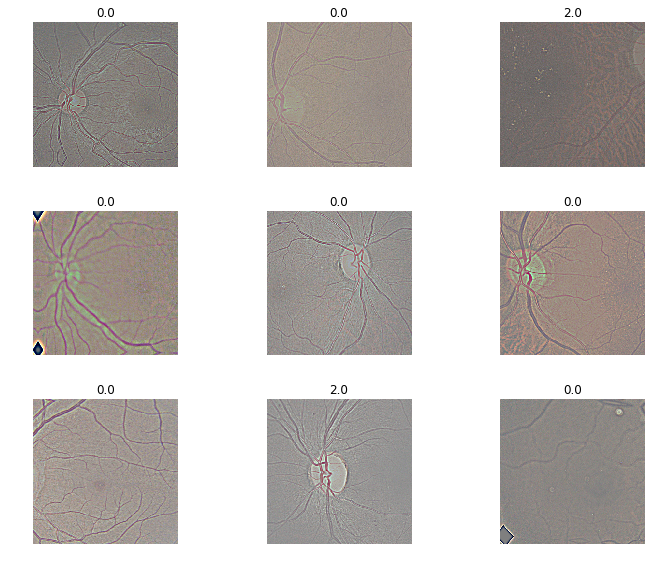

In [54]:
%%time
data.show_batch(rows=3, figsize=(10, 8))

## add test dataset

In [44]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)
test  = pd.read_csv(pp/'test.csv')

use test.sample to see different data

In [47]:
data.add_test(ImageList.from_df(test.sample(9),
                                '../input/aptos2019-blindness-detection',
                                folder='test_images',
                                suffix='.png'))

CPU times: user 720 ms, sys: 587 ms, total: 1.31 s
Wall time: 4.7 s


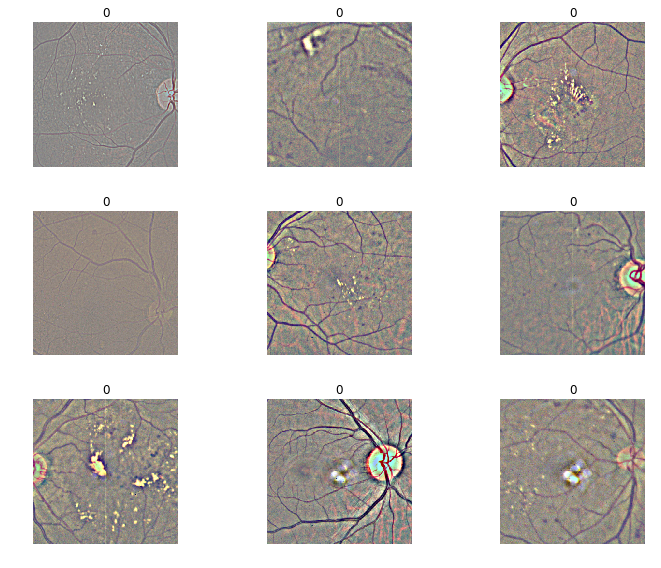

In [52]:
%%time
data.show_batch(rows=3, figsize=(10, 8), ds_type=DatasetType.Test)